## Child Phase 3 (Data Preparation):  v3

* Autorin: Anna (i3-Versicherung)
* Webseite: [Data Science Training - Kapitel 16](https://data-science.training/kapitel-16/)
* Datum: 23.03.2023

Wir führen eine Datenaufbereitung für eine binäre Klassifikationsanalyse mit Zielwert Child durch.

* Der Cabin-Wert zur PassengerId 873 wird gelöscht -- unnötig, da Cabin sowieso gelöscht wird.
* Schätzen von Embarked Missing Values: Modus 'S'
* Schätzen von Fare Missing Values: Konstanter Wert 7,896
* Neues Feature: TicketCount (aus Ticket)
* Neues Feature: LogFare (aus Fare und TicketCount)
* Neues Feature: Title (aus Name)
* Neues Feature: Firstname (aus Name)
* Neues Feature: FirstnameMeanAge (aus Firstname und Age !!!)

Wir benutzen One Hot Encoding, um sogenannte Dummy-Variablen als neue Features zu erzeugen.

* One Hot Encoding: Pclass, Sex, Embarked, Title => binäre Dummy-Variablen

Mit Hilfe einer Korrelationsanalyse werden wir Features filtern, deren Korrelationskoeffizient die Schwelle von 0,75 überschreitet. In diesem Fall sind die Features stark abhängig voneinander.

In [4]:
# Pandas Paket (Package) importieren
#  Datenstrukturen und Datenanalyse, I/O
#  https://pandas.pydata.org/pandas-docs/stable/
import pandas as pd
# NumPy Paket (Package) importieren
#  Mehrdimensionale Datenstrukturen (Vektoren, Matrizen, Tensoren, Arrays), Lineare Algebra
#  https://numpy.org/doc/
import numpy as np
# Klassen und Funktionen der scikit-learn Module importieren
#  Maschinelles Lernen, Algorithmen
#  https://scikit-learn.org/stable/modules/classes.html
from sklearn.model_selection import train_test_split
# Eigene Module importieren
#  zur Berechnung der Korrelationskoeffizienten
import sys
sys.path.append('../00_DST_Module/')
import dst_correlation_functions as cf

In [5]:
# Trainings- und Testdaten als Pandas Data Frame (df) aus CSV-Dateien laden
#  (KNIME: "CSV Reader")
df_train = pd.read_csv('../../data/titanic/original/train.csv')
df_test  = pd.read_csv('../../data/titanic/original/test.csv')

In [6]:
# Trainings- und Testdaten zusammenführen
#  (KNIME "Concatenate")
df = pd.concat([df_train, df_test], ignore_index=True)

In [7]:
# Datentypen automatisch konvertieren
df = df.convert_dtypes()

In [8]:
# Fehlende Werte prüfen
df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [9]:
# Falsche Kabinennummer löschen
#  (KNIME: "Rule Engine")
#display(df[df['Cabin'] == 'B51 B53 B55'])
#display(df[df['PassengerId'] == 873])
#df.loc[872, 'Cabin'] = np.nan
#display(df[df['PassengerId'] == 873])

In [10]:
# Fehlende Werte behandeln (d.h. schätzen) - Teil 1
#  (KNIME: "Missing Values")
# Embarked (Nominalskala): 2 fehlende Werte => Benutze den Modus (häufigster Wert)
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].dropna().mode()[0])

In [11]:
# Fehlende Werte behandeln (d.h. schätzen) - Teil 2
#  (KNIME: "Missing Values")
# Fare (Kardinalskala): 1 fehlender Wert => Benutze den konstanten Wert 7,896
#df['Fare'] = df['Fare'].fillna(7.896)
display(df[df['Fare'].isna()])
df.loc[1043, 'Fare'] = 7.896
display(df[df['PassengerId'] == 1044])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,<NA>,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,<NA>,<NA>,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,<NA>,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,7.896,<NA>,S


In [12]:
# Hilfsgröße TicketCount
#  (KNIME: "GroupBy", "Joiner", "Column Rename")
ticketCount = df.groupby('Ticket', as_index=False)['PassengerId'].count()
ticketCount = ticketCount.rename(columns={'PassengerId': 'TicketCount'})
df = df.merge(ticketCount, how='left', on='Ticket')

In [13]:
# Neues Features LogFare
#  (KNIME: "Math Formula")
df['LogFare']   = np.log( 1 + df['Fare'] / df['TicketCount'] )

In [14]:
# Neues Feature Title
#  (KNIME: "Cell Splitter", "Column Rename", "Table Creator", "Cell Replacer")
df['Title'] = df['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df['Title'] = df['Title'].replace(['Ms', 'Mlle'], 'Miss')
df['Title'] = df['Title'].replace(['Mme', 'Lady', 'the Countess', 'Dona'], 'Mrs')
df['Title'] = df['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Rare')

In [15]:
# Neues Feature Firstname
#  (KNIME: "Cell Splitter", "Column Rename", "Table Creator", "Cell Replacer")
df['Firstname'] = df['Name'].str.split(', ', expand=True)[1].str.split(' ', expand=True)[1]
df['Firstname'] = df['Firstname'].str.replace('(', '', regex=False)
df['Firstname'] = df['Firstname'].str.replace(')', '', regex=False)

In [16]:
# Neues Feature MeanAge und MedianAge berechnen
#  (KNIME: "GroupBy", "Joiner", "Missing Value", "Column Rename")
mean_age = df.groupby('Firstname', as_index=False)['Age'].mean()
mean_age = mean_age.rename(columns={'Age': 'FirstnameMeanAge'})
df = df.merge(  mean_age, how='left', on='Firstname')
df['FirstnameMeanAge'] = df['FirstnameMeanAge'].fillna(-1)

In [17]:
# One Hot Encoding => Dummy-Variablen
#  (KNIME: "One To Many")
df = pd.get_dummies(df, columns=['Pclass', 'Sex', 'Embarked', 'Title'], dtype=int)

In [18]:
# Ergebnis des Feature Engineering anzeigen
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PassengerId       1309 non-null   Int64  
 1   Survived          891 non-null    Int64  
 2   Name              1309 non-null   string 
 3   Age               1046 non-null   Float64
 4   SibSp             1309 non-null   Int64  
 5   Parch             1309 non-null   Int64  
 6   Ticket            1309 non-null   string 
 7   Fare              1309 non-null   Float64
 8   Cabin             295 non-null    string 
 9   TicketCount       1309 non-null   Int64  
 10  LogFare           1309 non-null   Float64
 11  Firstname         1309 non-null   string 
 12  FirstnameMeanAge  1309 non-null   Float64
 13  Pclass_1          1309 non-null   int32  
 14  Pclass_2          1309 non-null   int32  
 15  Pclass_3          1309 non-null   int32  
 16  Sex_female        1309 non-null   int32  


In [19]:
# Aufräumen: Attribute (manuell) herausfiltern: strings bzw. irrelevante Attribute
#  (KNIME "Column Filter")
df = df.drop(['Survived', 'Name', 'Ticket', 'Cabin', 'Firstname'], axis=1)
# Ergebnis anzeigen
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PassengerId       1309 non-null   Int64  
 1   Age               1046 non-null   Float64
 2   SibSp             1309 non-null   Int64  
 3   Parch             1309 non-null   Int64  
 4   Fare              1309 non-null   Float64
 5   TicketCount       1309 non-null   Int64  
 6   LogFare           1309 non-null   Float64
 7   FirstnameMeanAge  1309 non-null   Float64
 8   Pclass_1          1309 non-null   int32  
 9   Pclass_2          1309 non-null   int32  
 10  Pclass_3          1309 non-null   int32  
 11  Sex_female        1309 non-null   int32  
 12  Sex_male          1309 non-null   int32  
 13  Embarked_C        1309 non-null   int32  
 14  Embarked_Q        1309 non-null   int32  
 15  Embarked_S        1309 non-null   int32  
 16  Title_Master      1309 non-null   int32  


In [20]:
# Neues Feature: Child
#  (KNIME: "Rule Engine")
df['Child'] = (df['Age'] < 12).fillna(False).astype('int')

In [21]:
# Korrelationen: Numerische Attribute
corr_matrix = cf.dst_correlation_matrix(df)
display(corr_matrix)
#
corr_measures = cf.dst_correlation_measures_filtered(corr_matrix)
display(corr_measures)

,PassengerId,Age,SibSp,Parch,Fare,TicketCount,LogFare,FirstnameMeanAge,Pclass_1,Pclass_2,...,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Child
PassengerId,1.000000,0.028814,-0.055224,0.008942,0.031027,-0.010350,0.029938,0.032154,0.026495,0.022714,...,0.013406,0.048101,0.011585,-0.049836,0.002254,-0.049311,0.014116,0.036282,-0.005303,-0.033648
Age,0.028814,1.000000,-0.243699,-0.150917,0.177280,-0.185284,0.411531,0.726015,0.393198,-0.014986,...,0.063645,0.085777,-0.019458,-0.070001,-0.391259,-0.282792,0.183965,0.219841,0.172905,-0.540029
SibSp,-0.055224,-0.243699,1.000000,0.373587,0.160389,0.679444,-0.084967,-0.095829,-0.034256,-0.052419,...,-0.109609,-0.048396,-0.048678,0.073709,0.329171,0.075519,-0.243104,0.062537,-0.015618,0.324826
Parch,0.008942,-0.150917,0.373587,1.000000,0.221668,0.647029,-0.085951,-0.028811,-0.013033,-0.010057,...,-0.213125,-0.008635,-0.100943,0.071881,0.253482,0.064589,-0.304780,0.212113,-0.038036,0.322725
Fare,0.031027,0.177280,0.160389,0.221668,1.000000,0.479058,0.649504,0.176476,0.600115,-0.121166,...,-0.185746,0.286406,-0.129921,-0.170124,0.011678,0.090282,-0.192495,0.146511,0.025459,-0.015398
TicketCount,-0.010350,-0.185284,0.679444,0.647029,0.479058,1.000000,0.002616,-0.049101,0.097786,-0.045356,...,-0.172765,0.028193,-0.114046,0.047711,0.305164,0.109340,-0.286860,0.109071,-0.041981,0.330486
LogFare,0.029938,0.411531,-0.084967,-0.085951,0.649504,0.002616,1.000000,0.282929,0.789781,-0.030562,...,-0.129091,0.313262,-0.147629,-0.182560,-0.158237,0.006183,-0.086617,0.162111,0.108955,-0.203043
FirstnameMeanAge,0.032154,0.726015,-0.095829,-0.028811,0.176476,-0.049101,0.282929,1.000000,0.270981,0.060192,...,0.080887,-0.048418,-0.040047,0.068235,-0.149022,-0.261959,0.111858,0.183687,0.107949,-0.314878
Pclass_1,0.026495,0.393198,-0.034256,-0.013033,0.600115,0.097786,0.789781,0.270981,1.000000,-0.296526,...,-0.107371,0.325722,-0.166101,-0.181800,-0.084504,-0.013879,-0.099725,0.154347,0.121721,-0.121609
Pclass_2,0.022714,-0.014986,-0.052419,-0.010057,-0.121166,-0.045356,-0.030562,0.060192,-0.296526,1.000000,...,-0.028862,-0.134675,-0.121973,0.196532,-0.016933,-0.022679,-0.038595,0.064672,0.060296,0.020174


Sex_female  Sex_male      1.000000
            Title_Mr      0.870678
LogFare     Pclass_1      0.789781
Embarked_C  Embarked_S    0.778262
dtype: float64

### Schlussfolgerungen

Zwischen einigen Attributen (bzw. Features) gibt es starke Zusammenhänge:

* Sex_female           und Sex_male
* Sex_female           und Title_Mr
* LogFare              und Pclass_1
* Embarked_C           und Embarked_S

Wir können also jeweils eines dieser Feature eliminieren. Wir können beispielsweise die drei Features der linken Seite behalten:

* Sex_female
* LogFare
* Embarked_C

Und entsprechend können wir die vier Features der rechten Seite herausfiltern:

* Sex_male
* Title_Mr
* Pclass_1
* Embarked_S

Prinzipiell wäre aber auch eine Mischung möglich. In der KNIME Analytics Platform werden beispielsweise die folgenden vier Features herausgefiltert:

* Sex_female
* Title_Mr
* Embarked_C
* Pclass_1

Wir entscheiden uns dafür, die gleichen Features wie bei KNIME herauszufiltern, um mit den gleichen Daten weiterarbeiten zu können.

In [23]:
# Aufräumen: Attribute (manuell) herausfiltern
#  (KNIME "Column Filter")
df = df.drop(['Sex_female', 'Title_Mr', 'Embarked_C', 'Pclass_1'], axis=1)
# Ergebnis anzeigen
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PassengerId       1309 non-null   Int64  
 1   Age               1046 non-null   Float64
 2   SibSp             1309 non-null   Int64  
 3   Parch             1309 non-null   Int64  
 4   Fare              1309 non-null   Float64
 5   TicketCount       1309 non-null   Int64  
 6   LogFare           1309 non-null   Float64
 7   FirstnameMeanAge  1309 non-null   Float64
 8   Pclass_2          1309 non-null   int32  
 9   Pclass_3          1309 non-null   int32  
 10  Sex_male          1309 non-null   int32  
 11  Embarked_Q        1309 non-null   int32  
 12  Embarked_S        1309 non-null   int32  
 13  Title_Master      1309 non-null   int32  
 14  Title_Miss        1309 non-null   int32  
 15  Title_Mrs         1309 non-null   int32  
 16  Title_Rare        1309 non-null   int32  


In [24]:
# Daten aufteilen: Trainingsdaten vs. Anwenungsdaten - diesmal nach Age
#  (KNIME: "Row Splitter")
df_train = df[df['Age'].notna()]
df_app   = df[df['Age'].isna()]

In [25]:
# Age löschen
df_train = df_train.drop(['Age'], axis=1)
df_app   = df_app.drop(['Age'], axis=1)

In [26]:
# Verteilung der Werte prüfen und ausgeben
#  (KNIME: "Value Counter")
count_class = df_train['Child'].value_counts()
print(count_class)

Child
0    955
1     91
Name: count, dtype: int64


<Axes: ylabel='count'>

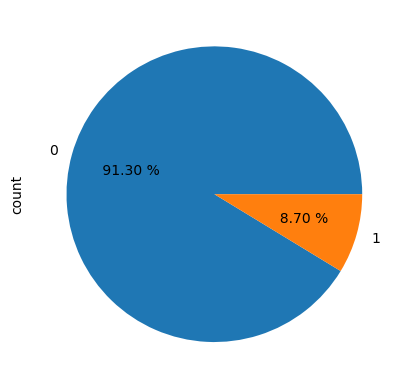

In [27]:
# Kuchendiagramm (Pie Chart) erstellen
#  (KNIME: "Pie chart")
count_class.plot(kind='pie', autopct='%6.2f %%')

In [28]:
# Trainingsdaten in zwei Partitionen (Training: 80 %, Validierung 20 %) aufteilen
#  (KNIME: "Partitioning")
df_train, df_test = train_test_split(df_train, test_size=0.2, random_state=0, shuffle=True)
#
print('Training  : ', df_train.shape[0])
print('Test      : ', df_test.shape[0])
print('Anwendung : ', df_app.shape[0])
print('Gesamt    : ', (df_train.shape[0] + df_test.shape[0] + df_app.shape[0]))
#
df_train = df_train.sort_values('PassengerId')
df_test  = df_test.sort_values('PassengerId')

Training  :  836
Test      :  210
Anwendung :  263
Gesamt    :  1309


In [29]:
# Irrelevante Attribute filtern
#  (KNIME: "Column Filter")
# Trainings- und Testdaten: PassengerId
df_train = df_train.drop(['PassengerId'], axis=1)
df_test  = df_test.drop(['PassengerId'], axis=1)
# Anwendungsdaten: Child
df_app = df_app.drop(['Child'], axis=1)

In [30]:
# Verteilung der Werte prüfen und ausgeben
#  (KNIME: "Value Counter")
count_class = df_train['Child'].value_counts()
print(count_class)

Child
0    762
1     74
Name: count, dtype: int64


<Axes: ylabel='count'>

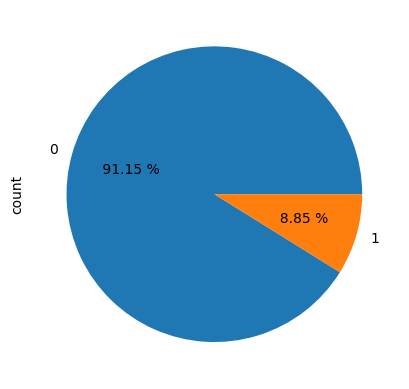

In [31]:
# Kuchendiagramm (Pie Chart) erstellen
#  (KNIME: "Pie chart")
count_class.plot(kind='pie', autopct='%6.2f %%')

In [32]:
# Verteilung der Werte prüfen und ausgeben
#  (KNIME: "Value Counter")
count_class = df_test['Child'].value_counts()
print(count_class)

Child
0    193
1     17
Name: count, dtype: int64


<Axes: ylabel='count'>

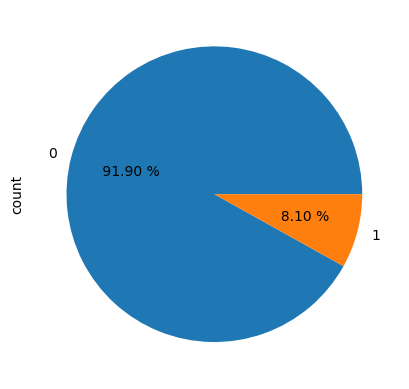

In [33]:
# Kuchendiagramm (Pie Chart) erstellen
#  (KNIME: "Pie chart")
count_class.plot(kind='pie', autopct='%6.2f %%')

In [34]:
display(df_train.head())

,SibSp,Parch,Fare,TicketCount,LogFare,FirstnameMeanAge,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mrs,Title_Rare,Child
0,1,0,7.25,1,2.110213,20.0,0,1,1,0,1,0,0,0,0,0
3,1,0,53.1,2,3.316003,36.0,0,0,0,0,1,0,0,1,0,0
4,0,0,8.05,1,2.202765,32.127119,0,1,1,0,1,0,0,0,0,0
6,0,0,51.8625,2,3.293287,54.0,0,0,1,0,1,0,0,0,0,0
7,3,1,21.075,5,1.651539,2.0,0,1,1,0,1,1,0,0,0,1


In [35]:
display(df_test.head())

,SibSp,Parch,Fare,TicketCount,LogFare,FirstnameMeanAge,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mrs,Title_Rare,Child
1,1,0,71.2833,2,3.601186,36.178571,0,0,0,0,0,0,0,1,0,0
2,0,0,7.925,1,2.188856,26.0,0,1,0,0,1,0,1,0,0,0
9,1,0,30.0708,2,2.774799,23.25,1,0,0,0,0,0,0,1,0,0
15,0,0,16.0,1,2.833213,32.0625,1,0,0,0,1,0,0,1,0,0
16,4,1,29.125,6,1.767154,14.666667,0,1,1,1,0,1,0,0,0,1


In [36]:
display(df_app.head())

,PassengerId,SibSp,Parch,Fare,TicketCount,LogFare,FirstnameMeanAge,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mrs,Title_Rare
5,6,0,0,8.4583,1,2.246893,41.375,0,1,1,1,0,0,0,0,0
17,18,0,0,13.0,1,2.639057,38.227273,1,0,1,0,1,0,0,0,0
19,20,0,0,7.225,1,2.107178,-1.0,0,1,0,0,0,0,0,1,0
26,27,0,0,7.225,1,2.107178,-1.0,0,1,1,0,0,0,0,0,0
28,29,0,0,7.8792,1,2.183711,28.6,0,1,0,1,0,0,1,0,0


In [37]:
# Daten als Excel-Dateien speichern
#  (KNIME: "Excel Writer")
# Trainingsdaten
df_train.to_excel('../../data/titanic/age/training_v3.xlsx', index=False)
# Testdaten
df_test.to_excel('../../data/titanic/age/test_v3.xlsx', index=False)
# Anwendungsdaten
df_app.to_excel('../../data/titanic/age/application_v3.xlsx', index=False)